In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from improved_diffusion.script_util import create_conditional_model_and_diffusion, args_to_dict
from train_ms import model_and_diffusion_defaults
import argparse

2024-09-18 16:41:47.068723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 16:41:47.082761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 16:41:47.087037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 16:41:47.100010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 16:41:47.926373: W tensorflow/compiler/tf2

In [3]:
defaults = {}
defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=1,
        use_ddim=False,
        model_path="/home/prateek/ms-diffusion/saved_models/ema_0.9999_080000.pt",
        output_dir=None,
        segmentation_model=None,
        learn_sigma=False,
        use_fp16=False,
        csv_file="testing_data_diffusion.csv",
        root_dir="/home/prateek/ms_project/ms_slice_data/",
        image_size=256,
        rescale_learned_sigmas=False,
        class_cond=False,
    )
defaults.update(model_and_diffusion_defaults())
defaults["rescale_learned_sigmas"] = False
args = argparse.Namespace(**defaults)
print(args)

Namespace(clip_denoised=True, num_samples=1, batch_size=1, use_ddim=False, model_path='/home/prateek/ms-diffusion/saved_models/ema_0.9999_080000.pt', output_dir=None, segmentation_model=None, learn_sigma=False, use_fp16=False, csv_file='testing_data_diffusion.csv', root_dir='/home/prateek/ms_project/ms_slice_data/', image_size=256, rescale_learned_sigmas=False, class_cond=False, num_channels=64, num_res_blocks=2, num_heads=2, num_heads_upsample=-1, attention_resolutions='16', dropout=0.0, sigma_small=False, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='', use_kl=False, predict_xstart=False, rescale_timesteps=True, use_checkpoint=False, use_scale_shift_norm=True)


In [4]:
device = "cuda:0"

model, diffusion = create_conditional_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()),
    )

In [6]:
checkpoint = torch.load(args.model_path, map_location=device, weights_only=True)

In [7]:
new_state_dict = {}
for key, value in checkpoint.items():
    # Remove 'module.' from the keys if it exists
    if key.startswith('module.'):
        new_key = key[7:]  # Remove 'module.' from the key
    else:
        new_key = key
    new_state_dict[new_key] = value

In [9]:
model.to(device)
model.load_state_dict(new_state_dict)
model.eval()

ConditionalUNet(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_c

In [8]:
from improved_diffusion.ms_datasets import load_data

In [9]:
test_dataloader = load_data(args.csv_file, args.root_dir, batch_size=1,distributed=False, train=False)

In [10]:
from counterfactual_ms import get_random_lesion_info
import os

In [11]:
test_df = pd.read_csv(os.path.join(args.root_dir, args.csv_file))

In [11]:
def preprocess(cond, device):
    model_kwargs = {
        k: v.to(device) for k, v in cond.items()
    }
    return model_kwargs

In [114]:
batch, cond = next(test_dataloader)

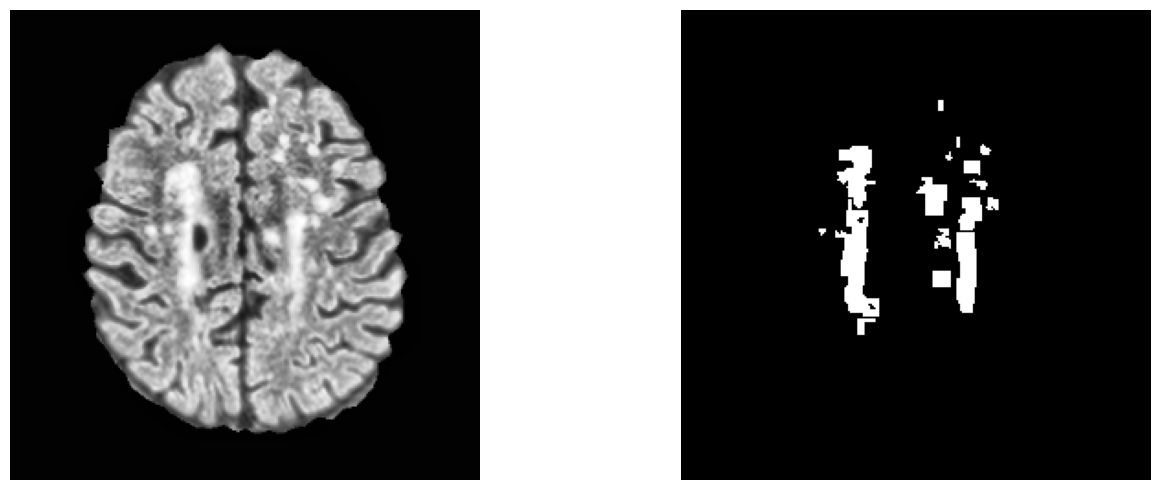

In [115]:
def plot_batch(batch, mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(batch, cmap='gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_batch(batch.squeeze(), cond["ground_truth"].squeeze())

In [116]:
cf_cond = get_random_lesion_info(test_df, args.batch_size)
print(cf_cond)

{'lesion_load': tensor([0.]), 'num_lesions': tensor([0.]), 'lesion': tensor([0.])}


In [117]:
batch = batch.to(device)
model_kwargs = preprocess(cond, device)
cf_model_kwargs = preprocess(cf_cond, device)
# cf_model_kwargs = preprocess(cond, device) # null intervention

In [118]:
_gt = model_kwargs.pop("ground_truth")
cf_model_kwargs.pop("ground_truth", None)

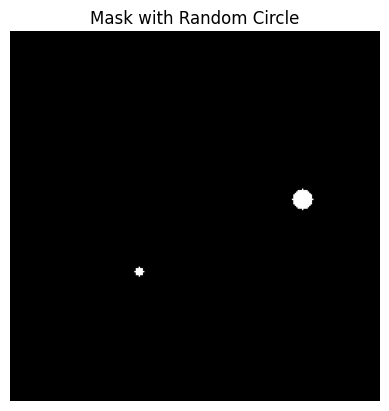

In [108]:
import random 
import matplotlib.pyplot as plt

def add_random_circles(tensor, lesion_load, num_lesions, min_radius=2, max_radius=7, center_bias=0.13):
    """
    Add multiple random circles to a randn tensor, with the values inside the circles set to 1.
    The circles will be biased to appear more towards the center of the image.

    Args:
        tensor (torch.Tensor): A randn tensor of shape (1, 1, 256, 256).
        lesion_load (float): Total area to be covered by the lesions (value between 0 and 1).
        num_lesions (int): The approximate number of lesions (circles) to be added.
        min_radius (int): Minimum radius for the circles.
        max_radius (int): Maximum radius for the circles.
        center_bias (float): Standard deviation of the Gaussian distribution as a fraction of the image size.
                             A smaller value means more circles will be closer to the center.

    Returns:
        torch.Tensor: Tensor with random circles added, where values inside the circles are set to 1.
    """
    # Ensure the tensor is the correct shape (1, 1, 256, 256)
    assert tensor.shape == (1, 1, 256, 256), "Tensor should have shape (1, 1, 256, 256)"
    
    # Convert to NumPy for easy manipulation
    mask_np = tensor.squeeze().cpu().numpy()
    h, w = mask_np.shape
    total_area = h * w
    
    # Total area that needs to be covered by the lesions based on lesion load
    target_area = lesion_load * total_area
    covered_area = 0
    lesion_count = 0
    
    # Center of the image (where the brain is located)
    center_x_mean = w // 2
    center_y_mean = h // 2

    # Standard deviation for the Gaussian distribution, controlling how spread out the circles are
    std_x = center_bias * w
    std_y = center_bias * h
    
    while lesion_count < num_lesions and covered_area < target_area:
        # Randomly choose a radius for the circle
        radius = random.randint(min_radius, max_radius)
        circle_area = np.pi * (radius ** 2)
        
        # If adding this circle exceeds the target area, adjust the radius
        if covered_area + circle_area > target_area:
            radius = int(np.sqrt((target_area - covered_area) / np.pi))
            circle_area = np.pi * (radius ** 2)
        
        # Choose a center for the circle, biased towards the center using a normal distribution
        center_x = int(np.clip(np.random.normal(center_x_mean, std_x), radius, w - radius))
        center_y = int(np.clip(np.random.normal(center_y_mean, std_y), radius, h - radius))
        
        # Generate a grid of coordinates
        y, x = np.ogrid[:h, :w]
        
        # Create a mask for the circle using the equation of a circle
        circle_mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2
        
        # Set the area inside the circle to 1
        mask_np[circle_mask] = 1
        
        # Update the covered area and lesion count
        covered_area += circle_area
        lesion_count += 1
    
    # Convert back to a tensor and reshape to (1, 1, 256, 256)
    return torch.tensor(mask_np).unsqueeze(0).unsqueeze(0)

def plot_mask(mask):
    """
    Plot the mask using matplotlib.

    Args:
        mask (torch.Tensor): A tensor of shape (1, 1, 256, 256).
    """
    # Convert tensor to NumPy for plotting
    mask_np = mask.squeeze().cpu().numpy()

    # Plot the mask
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask with Random Circle")
    plt.axis('off')
    plt.show()

targeted_mask = torch.zeros_like(_gt)
targeted_mask = add_random_circles(targeted_mask, lesion_load=90, num_lesions=2)
plot_mask(targeted_mask)

In [119]:
mask_model = torch.randn_like(_gt)
mask_cf = torch.zeros_like(_gt)
# mask_cf = torch.randn_like(_gt)
# mask_cf = targeted_mask.to(device)
model_kwargs["mask"] = mask_model
cf_model_kwargs["mask"] = mask_cf

In [45]:
def do_counterfactual(model, diffusion, batch, model_kwargs, cf_model_kwargs, args):
    print("abducting noise")
    abducted_noise = diffusion.ddim_sample_loop(
            model,
            (args.batch_size, 1, args.image_size, args.image_size),
            noise=batch,
            abduct=True,
            clip_denoised=args.clip_denoised,
            model_kwargs=model_kwargs,
        )
    print("denoising-> Estimating counterfactual")
    cf_sample = diffusion.ddim_sample_loop(
            model,
            (args.batch_size, 1, args.image_size, args.image_size),
            abduct=False,
            noise=abducted_noise,
            clip_denoised=args.clip_denoised,
            model_kwargs=cf_model_kwargs
        )
    return cf_sample

In [120]:
new_sample = do_counterfactual(model,  diffusion, batch, model_kwargs, cf_model_kwargs, args)

abducting noise
denoising-> Estimating counterfactual


In [121]:
orig_img = (batch*255).clamp(0,255)
cf_sample = (new_sample*255).clamp(0,255)

In [26]:
import matplotlib.pyplot as plt
from improved_diffusion.ms_datasets import LESION_LOAD_MAX, NUM_LESION_MAX

In [34]:
def rescale_values(cond, case=None):
    if case is None:
        lesion_load = cond["lesion_load"]*LESION_LOAD_MAX
        num_lesion = cond["num_lesions"]*NUM_LESION_MAX
    else:
        lesion_load = cond["lesion_load"]*LESION_LOAD_MAX*LESION_LOAD_MAX
        num_lesion = cond["num_lesions"]*NUM_LESION_MAX*NUM_LESION_MAX
    return lesion_load.cpu().numpy(), num_lesion.cpu().numpy(), cond["lesion"].cpu().numpy()

In [122]:
orig_vals = rescale_values(model_kwargs, case="orig")
print(orig_vals)
cf_vals = rescale_values(cf_model_kwargs, case="orig")
print(cf_vals)

(array([2355.], dtype=float32), array([16.], dtype=float32), array([1.], dtype=float32))
(array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32))


In [36]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    """
    Normalize the colorbar so that diverging colormaps have the midpoint
    set at a desired value, e.g., 0. Useful for showing diff images.
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        result = np.ma.masked_array(np.interp(result, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.squeeze(result)
        return result

def plot(orig_img, cf_sample, orig, cf, guiding_mask=None, title1="Original Image", title2="Counterfactual Image"):
    """
    Plot two images side by side with custom multi-line titles showing lesion load, number of lesions, and health status.
    Also plot the difference image with midpoint normalization and a colorbar.

    Args:
        orig_img (torch.Tensor): The original image tensor of shape (1, 1, 256, 256).
        cf_sample (torch.Tensor): The counterfactual image tensor of shape (1, 1, 256, 256).
        orig (tuple): Original values (lesion_load, num_lesions, health_status).
        cf (tuple): Counterfactual values (lesion_load, num_lesions, health_status).
        title1 (str): Title for the original image.
        title2 (str): Title for the counterfactual image.
    """
    # Remove extra dimensions (convert from shape (1,1,256,256) to (256,256))
    orig_img_np = orig_img.squeeze().cpu().numpy()
    cf_sample_np = cf_sample.squeeze().cpu().numpy()

    # Calculate the difference image
    diff = orig_img_np - cf_sample_np

    # Unpack the original and counterfactual values
    orig_lesion_load, orig_num_lesions, orig_health_status = orig
    cf_lesion_load, cf_num_lesions, cf_health_status = cf

    # Format the titles based on the original and counterfactual values
    orig_title = f"{title1}\nlesion_load={int(orig_lesion_load[0])}, n={int(orig_num_lesions[0])},\nhealthy={'False' if orig_health_status[0] == 1 else 'True'}"
    cf_title = f"{title2}\nlesion_load={int(cf_lesion_load[0])}, n={int(cf_num_lesions[0])},\nhealthy={'False' if cf_health_status[0] == 1 else 'True'}"

    # Create a figure with three subplots
    if guiding_mask is None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(orig_img_np, cmap='gray')
    axes[0].set_title(orig_title)
    axes[0].axis('off')  # Hide the axes

    # Plot the counterfactual image
    axes[1].imshow(cf_sample_np, cmap='gray')
    axes[1].set_title(cf_title)
    axes[1].axis('off')  # Hide the axes

    if guiding_mask is None:
        diff_idx = 2
    else:
        diff_idx = 3
        axes[2].imshow(guiding_mask.squeeze().cpu().numpy(), cmap='gray')
        axes[2].axis('off')
        axes[2].set_title("Guiding mask")

    # Plot the difference image with midpoint normalization and colorbar
    norm = MidpointNormalize(vmin=diff.min(), vmax=diff.max(), midpoint=0)
    cax = axes[diff_idx].imshow(diff, cmap='coolwarm', norm=norm)
    axes[diff_idx].set_title("Direct Effect")
    axes[diff_idx].axis('off')  # Hide the axes

    

    # Add a colorbar to the difference image
    fig.colorbar(cax, ax=axes[diff_idx], orientation="vertical")

    # Adjust layout to prevent title overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

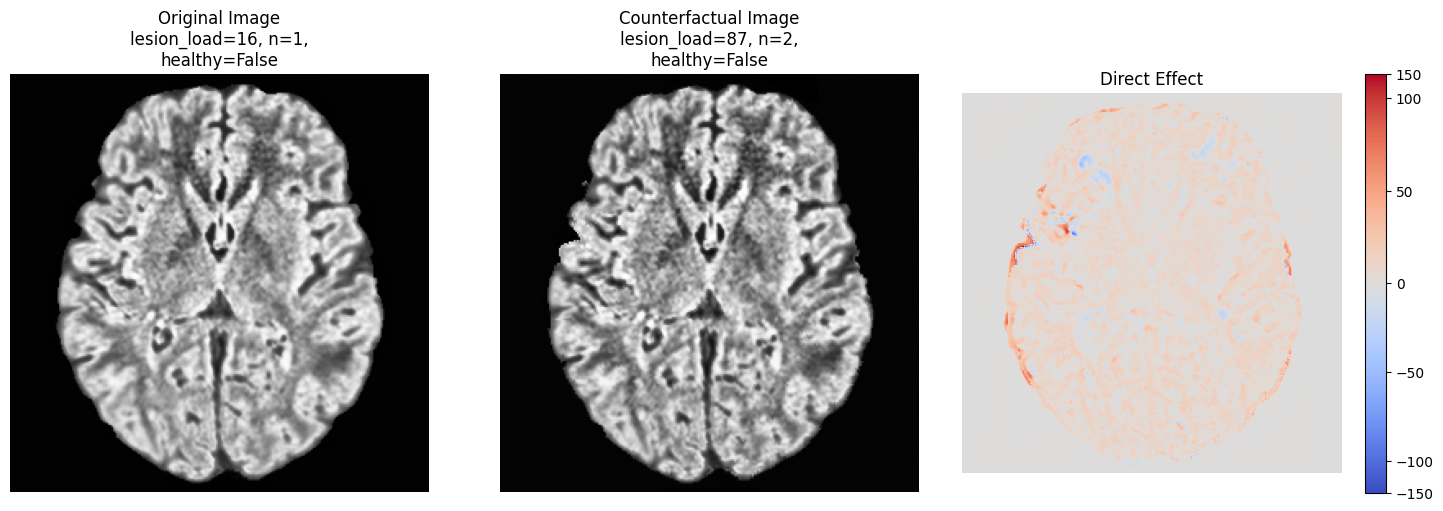

In [137]:
plot(orig_img, cf_sample, orig_vals, cf_vals)

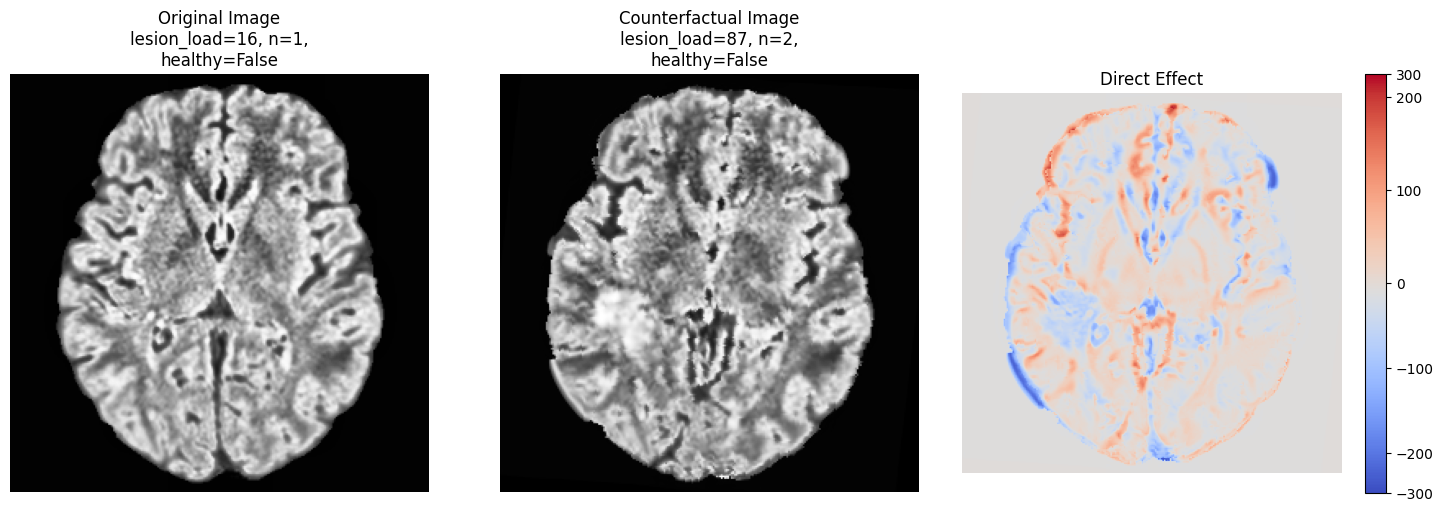

In [157]:
plot(orig_img, cf_sample, orig_vals, cf_vals)

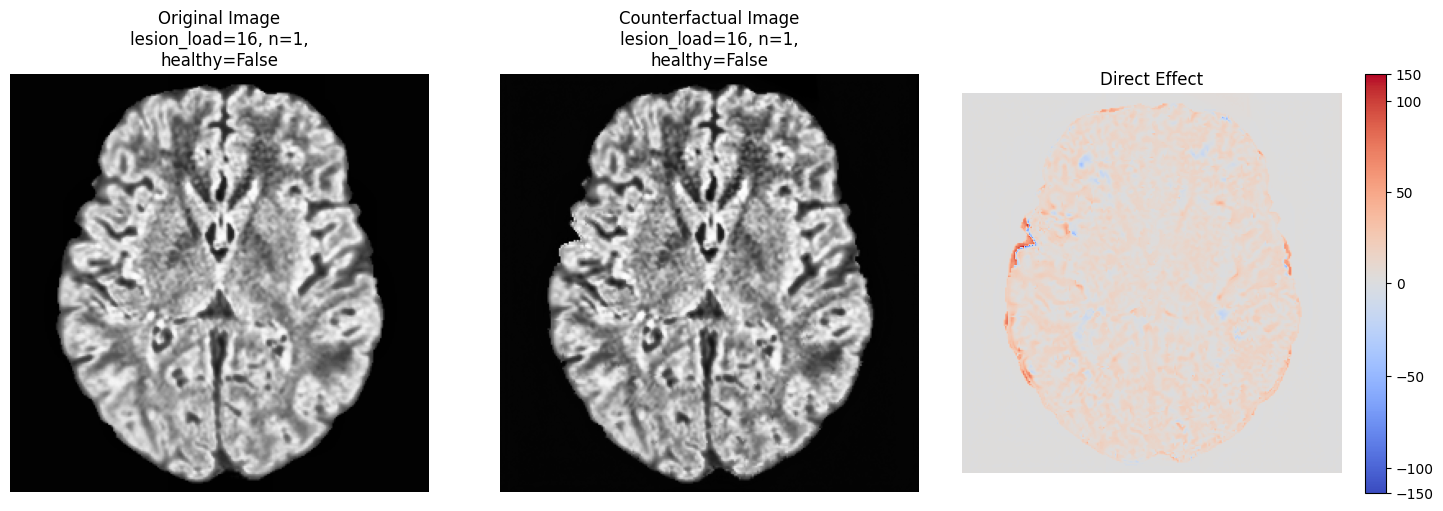

In [169]:
plot(orig_img, cf_sample, orig_vals, cf_vals)

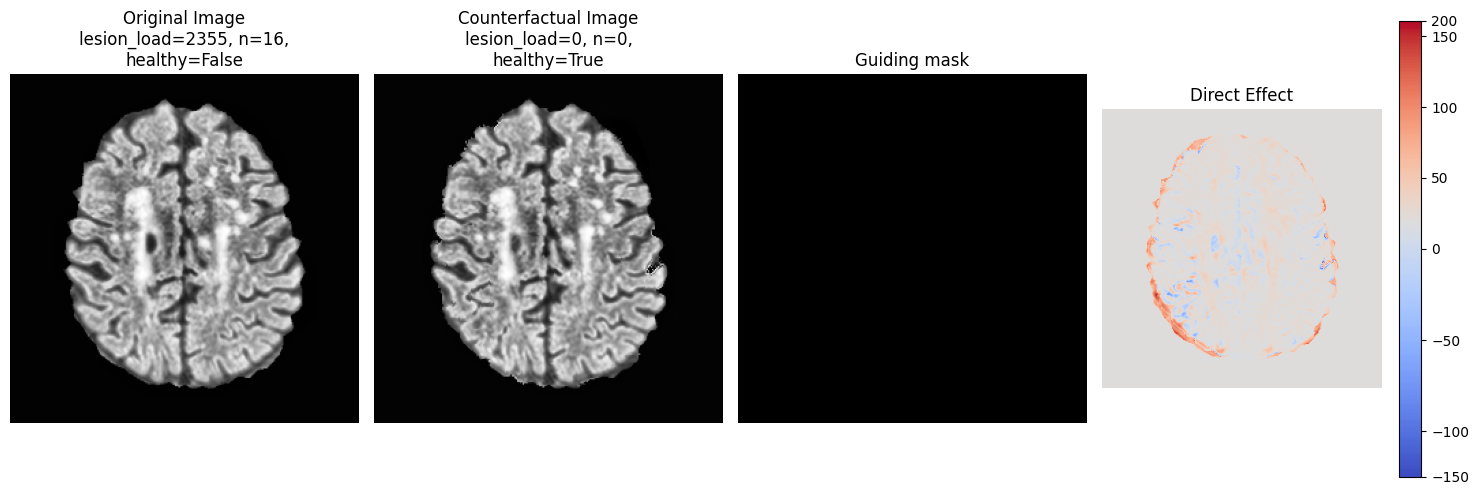

In [123]:
plot(orig_img, cf_sample, orig_vals, cf_vals, guiding_mask=cf_model_kwargs.get("mask"))

In [12]:
root_dir = "/mnt/recsys/prateek/synthetic_ms_data"
data_df = pd.read_csv(os.path.join(root_dir, "synthetic_data.csv"))

In [13]:
les_df = data_df[data_df.lesion == 1]

In [23]:
from torchvision import transforms
from PIL import Image

In [32]:
def get_random_lesion_mask_and_info(df, batch_size, root_dir):
    """
    Selects batch_size random rows containing lesion information and loads corresponding mask images.
    Applies the same normalization as during training and returns the mask, lesion_load, num_lesions,
    and lesion status as tensors for the batch.
    
    Args:
        df: DataFrame containing the lesion information and mask filenames.
        batch_size: The number of samples to load for this batch.
        root_dir: Directory where the mask images are stored.
    
    Returns:
        out_dict: A dictionary containing tensors for mask, lesion_load, num_lesions, and lesion status.
    """
    
    # Randomly select batch_size rows from the dataframe
    random_rows = df.sample(n=batch_size)
    
    # Lists to store data for the batch
    masks = []
    lesion_loads = []
    num_lesions_list = []
    lesion_statuses = []
    
    # Loop over each selected row
    for index, row in random_rows.iterrows():
        # Load the mask image from the "label" column
        mask_path = os.path.join(root_dir, row['label'])  # Assuming 'label' contains the mask filenames
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        mask = transforms.functional.to_tensor(mask)  # Convert to tensor (values between 0 and 1)
        mask = torch.where(mask > 0.5, torch.tensor(1.0), torch.tensor(0.0))  # Binarize the mask
        
        # Append the mask and the lesion information to the lists
        masks.append(mask)
        lesion_loads.append(row['lesion_load'] / LESION_LOAD_MAX**2)
        num_lesions_list.append(row['num_lesions'] / NUM_LESION_MAX**2)
        lesion_statuses.append(row['lesion'])
    
    # Stack the masks along the batch dimension
    masks = torch.stack(masks)  # Add channel dimension (B, 1, H, W)
    
    # Convert lists to tensors for lesion information
    out_dict = {
        "mask": masks,
        "lesion_load": torch.tensor(lesion_loads, dtype=torch.float32),
        "num_lesions": torch.tensor(num_lesions_list, dtype=torch.float32),
        "lesion": torch.tensor(lesion_statuses, dtype=torch.float32)  # Binary value
    }
    
    return out_dict

In [55]:
cond = get_random_lesion_mask_and_info(les_df, 1, root_dir)

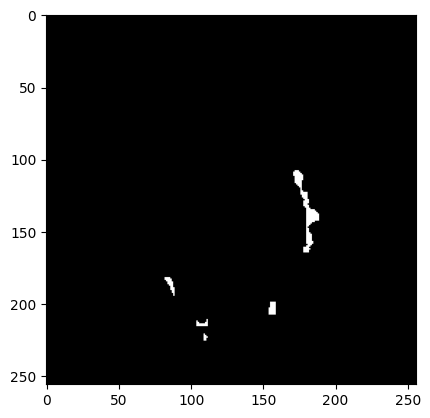

In [56]:
plt.imshow(cond["mask"].squeeze().squeeze().cpu().numpy(), cmap="gray")

In [29]:
sample_fn = (
            diffusion.p_sample_loop if not args.use_ddim else diffusion.ddim_sample_loop
        )

In [57]:
model_kwargs = preprocess(cond, device)

In [58]:
with torch.no_grad():
    sample = sample_fn(
        model,
        (1, 1, 256, 256),  # Batch size of 1, image size 256x256
        clip_denoised=True,
        model_kwargs=model_kwargs,
    )
    
# Post-process the sample (clamp and convert to uint8)
sample = (sample * 255).clamp(0, 255).to(torch.uint8)
sample = sample.permute(0, 2, 3, 1)  # Permute to (B, H, W, C)
sample = sample.contiguous().squeeze().squeeze()  # Remove batch dimension

(-0.5, 255.5, 255.5, -0.5)

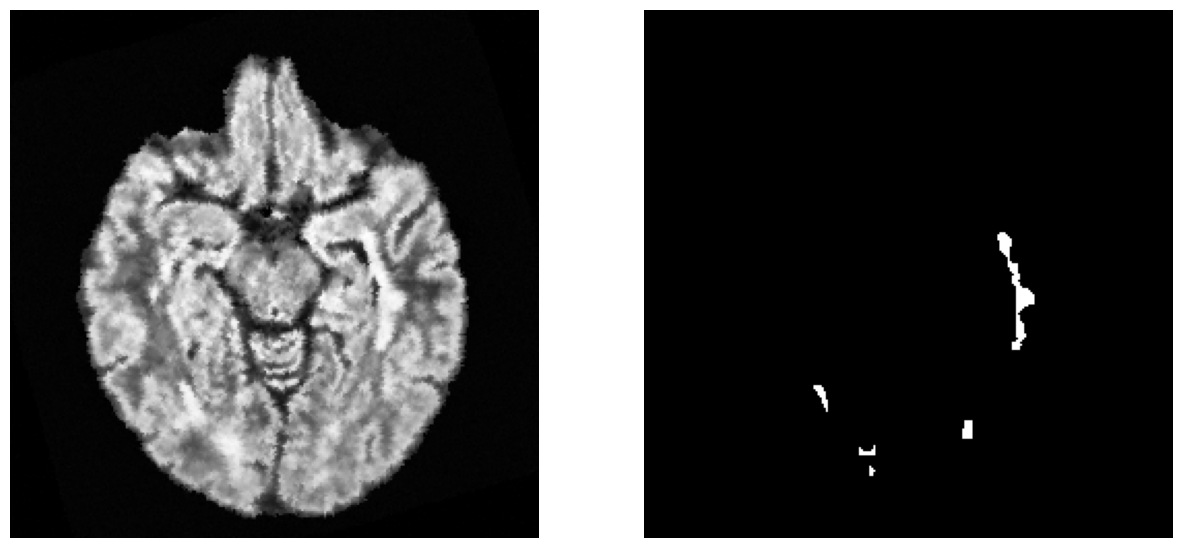

In [59]:
f, a = plt.subplots(1, 2, figsize=(15,15))
a[0].imshow(sample.cpu().numpy(), cmap='gray')
a[0].axis("off")
a[1].imshow(model_kwargs["mask"].squeeze().squeeze().cpu().numpy(), cmap="gray")
a[1].axis("off")